In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import keras_cv
import tqdm
from sklearn.manifold import TSNE

In [28]:
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True) #limits gpu memory

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
def preprocess(data, noise_dimensions, noise, shuffle):
    # Expand dimensions
    data = data.map(lambda img, img2: (tf.expand_dims(img, -1), tf.expand_dims(img2, -1)))
    # Cast to float32
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), tf.cast(target, tf.float32)))
    # Normalize data
    #data = data.map(lambda img, target: ((img/128.)-1., (target/128.)-1.))
    data = data.map(lambda img, img2: ((img/255), (img2/255)))
    # Add random noise 
    if noise:
        data = data.map(lambda img, target: (tf.add(img, tf.random.normal(img.shape, noise_dimensions[0], noise_dimensions[1], dtype=tf.float32)), target))
        #data = data.map(lambda img, target: (img + tf.random.normal(mean=noise_dimensions[0], stddev=noise_dimensions[1], shape=img.shape), target))
        data = data.map(lambda img, target: (tf.clip_by_value(img, 0, 1), target))
    if shuffle:
        data = data.shuffle(1000) # Shuffle the data
    data = data.batch(32) # Batch the data
    data = data.prefetch(tf.data.AUTOTUNE) # Prefetch the data
    return data

train_ds = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, x_test))

# preprocess(data, (mean, std), noise, shuffle)
train_ds_noisy = preprocess(train_ds, (0,0.5), noise=True, shuffle=True)
test_ds_noisy = preprocess(test_ds, (0,0.5), noise=True, shuffle=True)

print(train_ds_noisy.element_spec)

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))


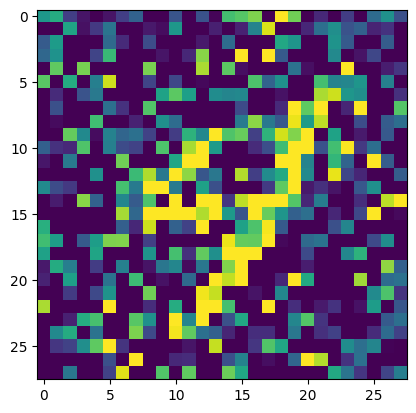

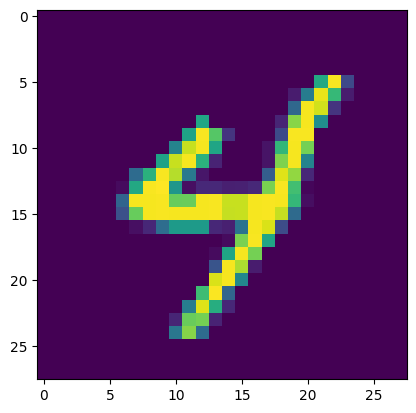

In [30]:
# Visualize the data
for img, target in train_ds_noisy.take(1):
    for i in img:
        i = np.reshape(i, (28,28))
        plt.imshow(i)
        plt.show()
        break
    for i in target:
        i = np.reshape(i, (28,28))
        plt.imshow(i)
        plt.show()
        break

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.model_layers = [
            tf.keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same"),
            tf.keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation="relu")
        ]

    def call(self, x):
        for operation in self.model_layers:
            x = operation(x)
        return x

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.model_layers = [
            tf.keras.layers.Dense(28*28, activation="relu"),
            tf.keras.layers.Reshape((28,28,1)),
            tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=1),
            tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=1),
            tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")
        ]

    def call(self, x):
        for operation in self.model_layers:
            x = operation(x)
        return x

In [33]:
class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()

        self.loss_function = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam()
        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]

        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    @tf.function
    def train(self,input):
        image, target = input
        with tf.GradientTape() as tape:
            prediction = self(image)
            loss = self.loss_function(target,prediction)     
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))    
        self.metrics[0].update_state(loss)

        return {m.name: m.result() for m in self.metrics}
    

    @tf.function
    def test(self,input):
        image, target = input
        prediction = self(image)
        loss = self.loss_function(target,prediction)
        self.metrics[0].update_state(loss)

        return {m.name: m.result() for m in self.metrics}


In [34]:
def training_loop(model, train_ds, test_ds, epochs):
  for epoch in range(epochs):
    print(f"Epoch {epoch}:")
        
    # Training:
    for data in tqdm.tqdm(train_ds, position=0, leave=True):
      metrics = model.train(data)

    # print the metrics
    print([f"{key} : {value.numpy()}" for (key, value) in metrics.items()])

    # reset all metrics (requires a reset_metrics method in the model)
    model.reset_metrics()    
        
    # Validation:
    for data in test_ds:
      metrics = model.test(data)
              
    print([f"test {key}: {value.numpy()}" for (key, value) in metrics.items()])

    # reset all metrics
    model.reset_metrics()


In [35]:
encoder = Encoder(10) # 10 is the latent dimension
decoder = Decoder()
autoencoder = Autoencoder(encoder, decoder)
history = training_loop(autoencoder, train_ds_noisy, test_ds_noisy, epochs=10)

Epoch 0:


100%|██████████| 1875/1875 [00:11<00:00, 166.38it/s]


['loss : 0.040478453040122986']
['test loss: 0.0313897468149662']
Epoch 1:


100%|██████████| 1875/1875 [00:10<00:00, 177.83it/s]


['loss : 0.02996528521180153']
['test loss: 0.02949639782309532']
Epoch 2:


100%|██████████| 1875/1875 [00:10<00:00, 178.61it/s]


['loss : 0.028262415900826454']
['test loss: 0.027553822845220566']
Epoch 3:


100%|██████████| 1875/1875 [00:10<00:00, 181.22it/s]


['loss : 0.02725907228887081']
['test loss: 0.02651827037334442']
Epoch 4:


100%|██████████| 1875/1875 [00:10<00:00, 181.46it/s]


['loss : 0.026515470817685127']
['test loss: 0.02587081305682659']
Epoch 5:


100%|██████████| 1875/1875 [00:10<00:00, 178.15it/s]


['loss : 0.025890521705150604']
['test loss: 0.02542809024453163']
Epoch 6:


100%|██████████| 1875/1875 [00:10<00:00, 179.68it/s]


['loss : 0.02547377347946167']
['test loss: 0.025244591757655144']
Epoch 7:


100%|██████████| 1875/1875 [00:10<00:00, 173.49it/s]


['loss : 0.025105535984039307']
['test loss: 0.02471792697906494']
Epoch 8:


100%|██████████| 1875/1875 [00:10<00:00, 171.86it/s]


['loss : 0.024807041510939598']
['test loss: 0.02430862747132778']
Epoch 9:


100%|██████████| 1875/1875 [00:11<00:00, 168.02it/s]


['loss : 0.02455040067434311']
['test loss: 0.024165593087673187']


In [36]:
predictions = autoencoder.predict(test_ds_noisy)

313/313 [==============================] - 1s 3ms/step


(28, 28, 1)


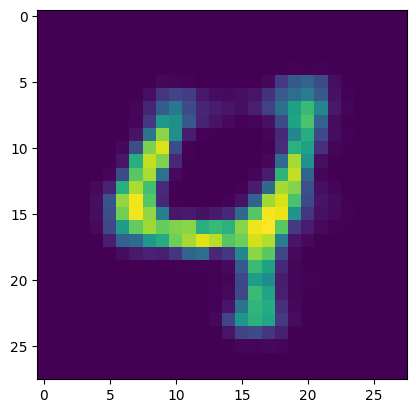

In [37]:
# Visualize the predictions wihtout noise
for i in predictions:
    print(i.shape)
    plt.imshow(i)
    plt.show()
    break


In [38]:
data = preprocess(test_ds, (0,0.5), True, False) # Create a dataset without shuffling
labels = y_test # Get the labels

encoded_imgs = encoder.predict(data)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 2ms/step


In [39]:
data_tsne = TSNE().fit_transform(encoded_imgs) # Reduce the dimensionality of the data using TSNE

## TSNE Visualization

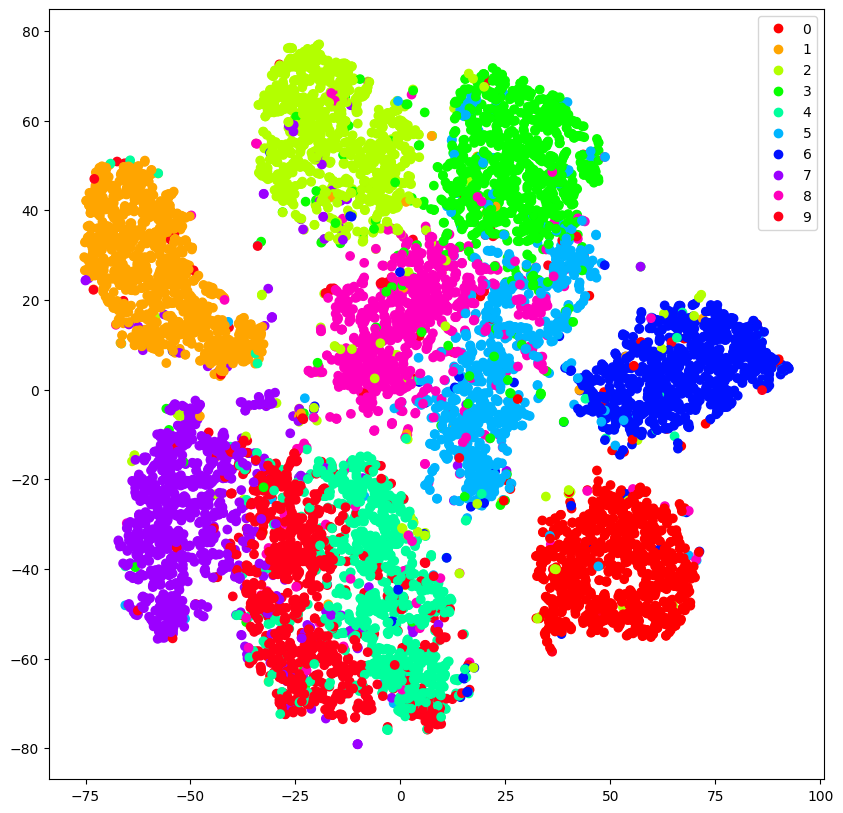

In [40]:
# Visualize the encoded data
legend = [str(l) for l in np.arange(10)]
fig = plt.figure(figsize=(10,10))
scatter = plt.scatter(data_tsne[:,0], data_tsne[:,1],cmap='hsv', c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=legend)

Most results are expected and seem natural e.g. 0 is close to 6 and 1 is close to 7

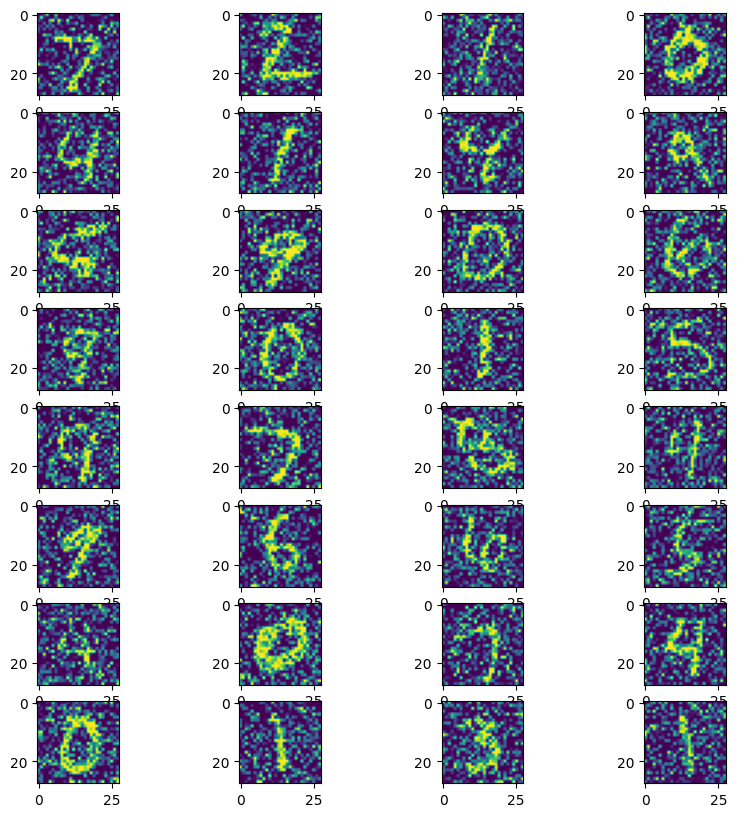

In [41]:
# Visualize sample data to pick good interpolation candidates
interpol_data= data.take(1)

imglist = []
for batch, labels in data.take(1):
    for img in batch:
        imglist.append(np.reshape(img, (28,28)))
fig = plt.figure(figsize=(10,10))
for i in range(32):
    ax = fig.add_subplot(8, 4, i+1)
    ax.imshow(imglist[i])
plt.show()

In [48]:
# Interpolation between 0 and 6
encoded_img_1 = encoder.predict(tf.convert_to_tensor(np.reshape(imglist[3], (1,28,28,1))))
encoded_img_2 = encoder.predict(tf.convert_to_tensor(np.reshape(imglist[11], (1,28,28,1))))
interpol_numbers = np.linspace(0,1,10)
interpol_imgs = []
for i in interpol_numbers:
    interpol_imgs.append(decoder.predict(i*encoded_img_1 + (1-i)*encoded_img_2))


1/1 [==============================] - 0s 20ms/step


## Interpolated Images

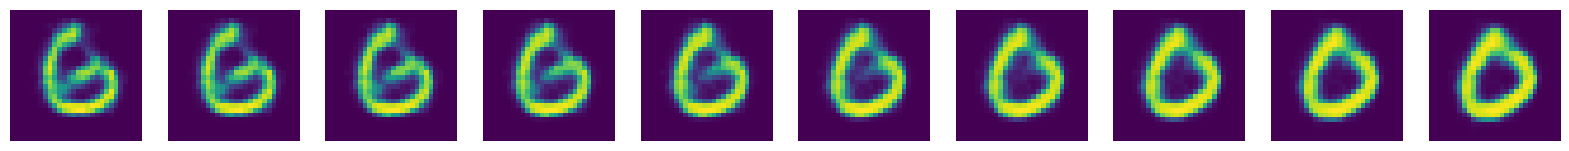

In [64]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(np.reshape(interpol_imgs[i], (28,28)))
    plt.axis('off')
plt.show()